In [1]:
import os
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import csv
import sys

import matplotlib.pyplot as plt
%matplotlib inline

# path to stylegan encoder locally
sys.path.insert(1, '/home/bobby/APhotoADay/data/stylegan-encoder')

import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

# path to puzer's age direction
puzer_age_direction = np.load("puzer_age_direction.npy")

from IPython.display import Markdown, display

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

/home/bobby/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bobby/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bobby/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bobby/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

/home/bobby/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bobby/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bobby/miniconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bobby/miniconda3/lib/python3.7/site-packages/tensorboar

In [2]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [3]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
# Receive input

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

real_data_path = "real_data" # input("Enter path for real data: ")
real_latent_path = "real_latent" # input("Enter path for real latent: ")
num_of_vid = input("Enter video number: ")
start_age = int(input("Enter start age (days): "))
end_age = int(input("Enter end age (days): "))
averaging_ratio = int(input("Enter averaging ratio (# photos per batch): "))
num_dimensions = int(input("Enter npy dimensions [0-default]: "))
method = int(input("Choose interpolator [0-standard, 1-puzer, 2-linear_regression]: ")) % 3

experiment = "video" + num_of_vid + "_plot_" + str(start_age) + "_to_" + str(end_age) + "_batch=" + str(averaging_ratio) + "_dimensions=" + ("default" if (num_dimensions == 0) else str(num_dimensions)) + "_method=" + ("standard" if (method == 0) else ("puzer" if (method == 1) else "regression"))
printmd("\n\n**Running experiment: " + experiment + "**", color="blue")

if not os.path.exists("Results/" + experiment):
    os.mkdir("Results/" + experiment)

Enter video number: 3
Enter start age (days): 4453
Enter end age (days): 6387
Enter averaging ratio (# photos per batch): 1
Enter npy dimensions [0-default]: 0
Choose interpolator [0-standard, 1-puzer, 2-linear_regression]: 2


<span style='color:blue'>

**Running experiment: video3_plot_4453_to_6387_batch=1_dimensions=default_method=regression**</span>

In [6]:
def findInterpolator(start, end):

    def interpolator(coefficient):
        return ((end - start) * coefficient) + start

    return interpolator

In [7]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [8]:
def findError(real, interpolator):
    line = interpolator(1) - interpolator(0)
    
    normalizedLine = line * (1/np.linalg.norm(line))
    
    distanceLine = interpolator(0) - real - (np.dot((interpolator(0) - real), normalizedLine) * normalizedLine)
    
    return real + distanceLine, np.linalg.norm(distanceLine)

In [9]:
def average(vectors):
    return sum(vectors)/len(vectors)

In [10]:
def reduceDimension(matrix, dimensionsToLeave):
    
    shape = matrix.shape
    
    if (dimensionsToLeave == 0):
        return matrix, np.zeros(shape)
    
    matrix = matrix.flatten()
    
    aux = matrix
    
    for i in range(0, dimensionsToLeave * 512):
        aux[i] = 0
    
    return np.reshape(matrix - aux, shape), np.reshape(aux, shape)

def restoreDimension (matrix, truncated):
    return matrix + truncated

In [11]:
#    Given a data set of the form
#    ((original photo, original age, target age), target photo)
#    We take some part of the data set and use it to train a linear model
#    We reserve some of the data to test it afterwards

#    photos should be npy
#    input = lists of the data (should all be the same size and flattened)
#    output = linear regression interpolator
#    note that data can come from multiple people, the more data, the more accurate
def findRegressor(start_photos, start_ages, target_ages, target_photos):

    X = []
    Y = []

    for i in range(len(start_photos)):
        X.append(np.array([start_photos[i], start_ages[i], target_ages[i]]))
        Y.append(target_photos[i])
    

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    regressor = LinearRegression()  
    regressor.fit(X_train, Y_train)

    #print("accuracy = " + str(testModel(X_train, Y_train, regressor)))

    return regressor, X_test, Y_test

#    input = list of data to test on and regressor to test
#    output = accuracy in MSE
def testModel(X, Y, regressor):

    Y_pred = regressor.predict (X)

    MSE = metrics.mean_squared_error (Y, Y_pred)

    return MSE


# TESTING FROM HERE DOWN REMOVE THIS DURING USE #


# data1 = []
# data2 = []
# data3 = []

# results = []
# for i in range(1000):
#     data1.append(np.array(np.random.rand()))
#     data2.append(np.array(np.random.rand()))
#     data3.append(np.array(np.random.rand()))
#     results.append(np.array([np.power(data1[i], 1),data2[i], data3[i]]))

# print(np.around(data1, decimals=3))
# print(np.around(data2, decimals=3))
# print(np.around(data3, decimals=3))
# print(np.around(results, decimals=3))

# regressor, X_test, Y_test = findInterpolator(data1, data2, data3, results)

# print (testModel(X_test, Y_test, regressor))

[0.68  0.618 0.335 0.753 0.681 0.921 0.697 0.475 0.467 0.751 0.131 0.485
 0.168 0.015 0.724 0.469 0.581 0.728 0.396 0.763 0.614 0.184 0.526 0.627
 0.2   0.656 0.636 0.542 0.615 0.681 0.547 0.459 0.361 0.615 0.596 0.966
 0.721 0.438 0.746 0.759 0.728 0.987 0.89  0.158 0.304 0.766 0.935 0.488
 0.323 0.958 0.733 0.721 0.766 0.117 0.744 0.877 0.667 0.955 0.004 0.415
 0.985 0.309 0.854 0.557 0.565 0.646 0.132 0.547 0.683 0.42  0.655 0.813
 0.972 0.014 0.117 0.712 0.973 0.85  0.255 0.202 0.094 0.108 0.742 0.765
 0.64  0.797 0.372 0.749 0.316 0.964 0.004 0.399 0.891 0.515 0.537 0.448
 0.074 0.183 0.448 0.934 0.095 0.099 0.059 0.206 0.596 0.832 0.813 0.706
 0.276 0.647 0.858 0.21  0.157 0.293 0.758 0.827 0.952 0.734 0.924 0.545
 0.622 0.465 0.86  0.431 0.422 0.247 0.416 0.427 0.719 0.581 0.945 0.121
 0.139 0.381 0.999 0.563 0.448 0.588 0.577 0.042 0.987 0.984 0.68  0.17
 0.474 0.059 0.84  0.471 0.246 0.989 0.499 0.421 0.602 0.04  0.609 0.11
 0.603 0.978 0.879 0.519 0.765 0.703 0.877 0.75  0.18

TypeError: findInterpolator() takes 2 positional arguments but 4 were given

In [10]:
# Create fake npy's and csv file

fake_latent_path = "fake_latent" # input("Enter path for fake latent: ")

if not os.path.exists(fake_latent_path):
    os.mkdir(fake_latent_path)

csv_file = "Results/" + experiment + "/" + experiment + ".csv"

real_latent_dir = os.listdir(real_latent_path)
files = sorted(real_latent_dir, key=lambda x: int(os.path.splitext(x)[0]))

start_age_npy, aux= reduceDimension (np.load(real_latent_path + "/" + str(start_age) + ".npy"), num_dimensions)
end_age_npy, aux = reduceDimension (np.load(real_latent_path + "/" + str(end_age) + ".npy"), num_dimensions)

if method == 0: # Standard
    interpolator = findInterpolator(start_age_npy.flatten(), end_age_npy.flatten())
else if method == 1: # Puzer
    interpolator = findInterpolator(start_age_npy.flatten(), (start_age_npy + puzer_age_direction).flatten())
else if method == 2: # Linear Regression
    interpolator, X_test, Y_test = findRegressor(data1, data2, data3, results)
    
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    #if averaging_ratio == 1:
    #    for real_npy in files:
    #        shape = np.load(real_latent_path + "/" + real_npy).shape   
    #        fake_npy, MSE = findError(np.load(real_latent_path + "/" + real_npy).flatten(), interpolator, num_dimensions) # real should be latent
    #        fake_npy_aux = np.reshape(fake_npy, shape)
    #        np.save(fake_latent_path + "/" + real_npy, fake_npy_aux)
    #        writer.writerow([real_npy[:-4], MSE])
            
    if averaging_ratio >= 1:
        vectors_left = len(files)
        batch = []
        batch_average_age = 0
        
        for real_npy in files:
            
            if (len(batch) < averaging_ratio and vectors_left > 0):
                batch.append(np.load(real_latent_path + "/" + real_npy).flatten())
                batch_average_age += int(real_npy[:-4])
                vectors_left -= 1
                continue
                
            batch_average_age /= len(batch)
            shape = np.load(real_latent_path + "/" + real_npy).shape
            batch_aux, batch_truncated = reduceDimension(average(batch), num_dimensions)
            fake_npy, MSE = findError(batch_aux.flatten(), interpolator)
            fake_npy_aux = np.reshape(fake_npy, shape)
            np.save(fake_latent_path + "/" + str(int(batch_average_age)) + ".npy", fake_npy_aux + np.reshape(batch_truncated, shape))
            writer.writerow([str(batch_average_age), MSE])
            
            batch = []
            batch_average_age = 0

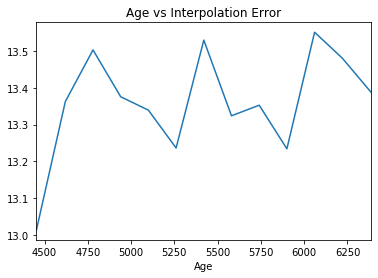

In [11]:
# Display and save plot

data = pd.read_csv(csv_file).set_index('Age')
data_plot = data.plot(title = "Age vs Interpolation Error", legend = None)

data_plot.get_figure().savefig("Results/" + experiment + "/" + experiment + ".png")

In [12]:
def generate_image(latent_vector, size):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((size, size))

def show(latent_vector):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    ax[i].imshow(generate_image(latent_vector))
    ax[i].set_title(latent_vector)
    [x.axis('off') for x in ax]
    plt.show()

In [13]:
# Decode fakes

fake_data_path = "fake_data" # input("Enter path for fake data: ")

if not os.path.exists(fake_data_path):
    os.mkdir(fake_data_path)

for file in os.listdir(fake_latent_path):
    img = generate_image(np.load(fake_latent_path + "/" + file), 1024)
    img.save(fake_data_path + "/" + file[:-4] + ".png")

In [14]:
# Create videos

from distutils.dir_util import copy_tree
import shutil

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

# Real video

shutil.copytree("real_data", "real_temp")
# shutil.copytree(real_data_path, "real_temp")
num_reals = len(next(os.walk("real_temp"))[2])

os.chdir("/home/bobby/APhotoADay/True_vs_Learned/real_temp")

os.system("python3 ../rename3.py . 0")
os.system("ffmpeg -f image2 -framerate 25 -pattern_type sequence -start_number 0 -r " + str(num_reals / 6) 
          + " -i %d.png -vcodec libx264 -acodec aac real_broken.mp4")
os.system("ffmpeg -i real_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p real.mp4")

shutil.copy('real.mp4', "/home/bobby/APhotoADay/True_vs_Learned/Results/" + experiment)

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")
shutil.rmtree("/home/bobby/APhotoADay/True_vs_Learned/real_temp")

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

# Fake video

shutil.copytree("fake_data", "fake_temp")
# shutil.copytree(fake_data_path, "fake_temp")
num_fakes = len(next(os.walk("fake_temp"))[2])

os.chdir("/home/bobby/APhotoADay/True_vs_Learned/fake_temp")

os.system("python3 ../rename3.py . 0")
os.system("ffmpeg -f image2 -framerate 25 -pattern_type sequence -start_number 0 -r " + str(num_fakes / 6) 
          + " -i %d.png -vcodec libx264 -acodec aac fake_broken.mp4")
os.system("ffmpeg -i fake_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p fake.mp4")

shutil.copy('fake.mp4', "/home/bobby/APhotoADay/True_vs_Learned/Results/" + experiment)

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")
shutil.rmtree("/home/bobby/APhotoADay/True_vs_Learned/fake_temp")

os.chdir("/home/bobby/APhotoADay/True_vs_Learned")

In [15]:
printmd("\n\n**Experiment " + experiment + " successfully finished**", color="green")

<span style='color:green'>

**Experiment video3-demo_plot_4380_to_6540_batch=15_dimensions=default_method=standard successfully finished**</span>